<a href="https://colab.research.google.com/github/trisha-agni/makemore_MLP_2/blob/main/makemore_MLP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# character vocab + mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build dataset
block_size = 3 # context length

def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [14]:
# MLP revised
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # *0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
  p.requires_grad = True

11897


In [15]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # creating minibatches
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # (32, 3, 10)
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors into (32, 30)
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer (32, 200)
  logits = h @ W2 + b2 # output layer (32, 27)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # break

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


In [8]:
# print(h.shape)
# plt.figure(figsize=(20,10))
# plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In [9]:
# plt.hist(h.view(-1).tolist(), 50);

In [10]:
# plt.hist(hpreact.view(-1).tolist(), 50);

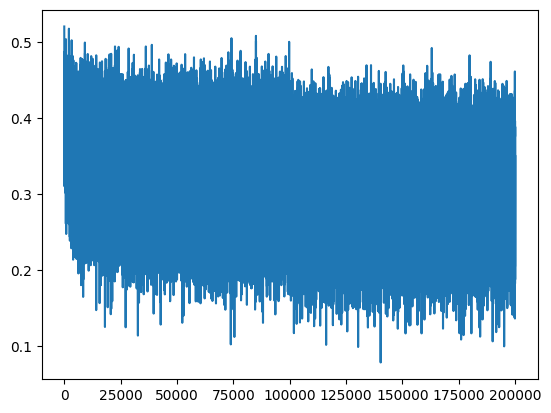

In [16]:
plt.plot(lossi)

In [17]:
@torch.no_grad() # decorator that disables gradient tracking
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


In [13]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # forward pass the neural network
    emb = C[torch.tensor([context])] # (1,block_size,n_embd)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift context window + track samples
    context = context[1:] + [ix]
    out.append(ix)
    # if special token '.' is sampled --> break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) # decode + print generated word

mora.
mayah.
see.
mad.
ryll.
renvestendraegusteredielin.
shi.
jen.
edeiseananar.
kayzion.
kamin.
shubergianaiya.
kinde.
jennex.
teron.
ububynder.
yarue.
els.
kayshaykella.
hal.
